In [53]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

In [54]:
def parser(x):
	return datetime.strptime( x, '%Y-%m-%d')
 
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)
 
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

# **Dataset Birth**

In [55]:
dataset = pd.read_csv('/content/drive/My Drive/BCML/datasets/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

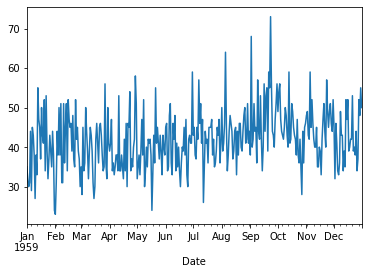

In [56]:
dataset.plot()
plt.show()

In [57]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [58]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-3
1,-3.0,-2
2,-2.0,1
3,1.0,13
4,13.0,-15
...,...,...
359,-10.0,3
360,3.0,15
361,15.0,-4
362,-4.0,7


In [59]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [60]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [61]:
scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Baseline model

In [62]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.2888 - val_loss: 0.1612
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2751 - val_loss: 0.1516
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2619 - val_loss: 0.1436
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2502 - val_loss: 0.1365
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2404 - val_loss: 0.1301
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.2305 - val_loss: 0.1248
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2217 - val_loss: 0.1204
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2156 - val_loss: 0.1159
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2077 - val_loss: 0.1125
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.2023 - val_loss: 0.1094
Epoch 11/1000
9/9 

In [63]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

3/3 - 0s - loss: 0.0694
Test loss: 0.06940607726573944


In [64]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
732,0.110770,0.069397,732
858,0.110767,0.069397,858
785,0.110775,0.069397,785
751,0.110765,0.069397,751
859,0.110763,0.069397,859
...,...,...,...
4,0.240365,0.130101,4
3,0.250212,0.136457,3
2,0.261920,0.143645,2
1,0.275056,0.151645,1


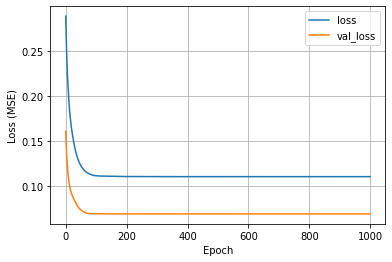

In [65]:
plot_loss(history) # epoch vs loss graph

# Deeper model

In [66]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.1190 - val_loss: 0.0725
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1165 - val_loss: 0.0714
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1146 - val_loss: 0.0709
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1133 - val_loss: 0.0706
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1124 - val_loss: 0.0702
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1120 - val_loss: 0.0700
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1115 - val_loss: 0.0698
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1112 - val_loss: 0.0696
Epoch 9/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1110 - val_loss: 0.0695
Epoch 10/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1109 - val_loss: 0.0695
Epoch 11/1000
9/9 

In [67]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
420,0.081421,0.053958,420
339,0.081896,0.053965,339
824,0.081237,0.053996,824
318,0.081682,0.054019,318
419,0.081503,0.054025,419
...,...,...,...
4,0.112438,0.070247,4
3,0.113302,0.070555,3
2,0.114648,0.070867,2
1,0.116467,0.071374,1


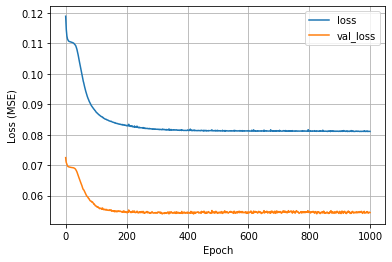

In [68]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider model

In [69]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.0886 - val_loss: 0.0565
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0852 - val_loss: 0.0557
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0841 - val_loss: 0.0553
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0551
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0548
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0547
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0822 - val_loss: 0.0547
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0542
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0816 - val_loss: 0.0542
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0818 - val_loss: 0.0546
Epoch 11/1000
9/9 

In [70]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
19,0.080894,0.054137,19
10,0.081331,0.054159,10
11,0.081266,0.054173,11
7,0.082119,0.054185,7
15,0.080846,0.054208,15
...,...,...,...
666,0.080348,0.056086,666
657,0.080353,0.056143,657
974,0.080392,0.056205,974
941,0.080483,0.056399,941


# **LSTM**

In [71]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 22ms/step - loss: 0.1084 - val_loss: 0.0674
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1054 - val_loss: 0.0656
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1030 - val_loss: 0.0643
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1009 - val_loss: 0.0631
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0992 - val_loss: 0.0621
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0972 - val_loss: 0.0613
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0957 - val_loss: 0.0605
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0942 - val_loss: 0.0598
Epoch 9/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0929 - val_loss: 0.0592
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0917 - val_loss: 0.0586
Epoch 11/1000
9/9 

In [72]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
78,0.080961,0.054192,78
57,0.080617,0.054216,57
87,0.080516,0.054277,87
210,0.080444,0.054277,210
63,0.080698,0.054279,63
...,...,...,...
4,0.099154,0.062077,4
3,0.100930,0.063094,3
2,0.102957,0.064289,2
1,0.105391,0.065582,1


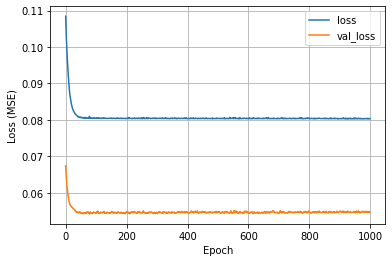

In [73]:
plot_loss(lstm_model_history)

# **Kesimpulan**

Berdasarkan perhitungan diatas didapatkan hasil:

```
Baseline Model: Val_loss 0.069397 Epoch 732
Deeper Model: Val_loss 0.053958 Epoch 420
Wider Model: Val_loss 0.054137 Epoch 19
LSTM: Val_loss 0.054192 Epoch 78
```
melihat dari hasil val_loss yang ada maka dapat di simpulkan **Deeper model** mendapatkan hasil yang **terbaik** meskipun perbedaannya hanya sedikit tetapi karena val_loss semakin kecil semakin baik jadi kita ambil yang paling kecil.
